In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import random
import string

In [2]:
results = {}

## Generate Test Data

In [3]:
def generate_test_data(nrows=100000, numerical_cols=2000, text_cols=0, text_length=10):
    ncols = numerical_cols + text_cols
    s = "".join([random.choice(string.ascii_letters)
                 for _ in range(text_length)])
    data = pd.concat([pd.DataFrame(np.random.random(size=(nrows, numerical_cols))),
                      pd.DataFrame(np.full(shape=(nrows, text_cols), fill_value=s))],
                     axis=1, ignore_index=True)
    data.columns = [str(i) for i in data.columns]
    return data

In [4]:
df = generate_test_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 2000 entries, 0 to 1999
dtypes: float64(2000)
memory usage: 1.5 GB


## Parquet

### Size

In [7]:
parquet_file = Path('test.parquet')

In [8]:
df.to_parquet(parquet_file)
size = parquet_file.stat().st_size

### Read

In [9]:
%%timeit -o
df = pd.read_parquet(parquet_file)

809 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 809 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [10]:
read = _

In [11]:
parquet_file.unlink()

### Write

In [12]:
%%timeit -o
df.to_parquet(parquet_file)
parquet_file.unlink()

12.1 s ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 12.1 s ± 32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [13]:
write = _

### Results

In [14]:
results['parquet'] = {'read': read.all_runs, 'write': write.all_runs, 'size': size}

## HDF5

In [15]:
test_store = Path('index.h5')

### Fixed Format

#### Size

In [16]:
with pd.HDFStore(test_store) as store:
    store.put('file', df)
size = test_store.stat().st_size

#### Read

In [17]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.get('file')

449 ms ± 9.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 449 ms ± 9.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [18]:
read = _

In [19]:
test_store.unlink()

#### Write

In [20]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.put('file', df)
test_store.unlink()

4.2 s ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 4.2 s ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [21]:
write = _

#### Results

In [22]:
results['hdf_fixed'] = {'read': read.all_runs, 'write': write.all_runs, 'size': size}

### Table Format

#### Size

In [23]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
size = test_store.stat().st_size    

#### Read

In [24]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    df = store.get('file')

508 ms ± 9.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 508 ms ± 9.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [25]:
read = _

In [26]:
test_store.unlink()

#### Write

Note that `write` in table format does not work with text data.

In [27]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
test_store.unlink()    

2.92 s ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2.92 s ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [28]:
write = _

#### Results

In [29]:
results['hdf_table'] = {'read': read.all_runs, 'write': write.all_runs, 'size': size}

### Table Select

#### Size

In [30]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
size = test_store.stat().st_size 

#### Read

In [31]:
company = 'APPLE INC'

In [32]:
# %%timeit
# with pd.HDFStore(test_store) as store:
#     s = store.select('file', 'company = company')

In [33]:
# read = _

In [34]:
# test_store.unlink()

#### Write

In [35]:
# %%timeit
# with pd.HDFStore(test_store) as store:
#     store.append('file', df, format='t', data_columns=['company', 'form'])
# test_store.unlink() 

In [36]:
# write = _

#### Results

In [37]:
# results['hdf_select'] = {'read': read.all_runs, 'write': write.all_runs, 'size': size}

## CSV

In [38]:
test_csv = Path('test.csv')

### Size

In [39]:
df.to_csv(test_csv)
test_csv.stat().st_size

3854558165

### Read

In [40]:
%%timeit -o
df = pd.read_csv(test_csv)

31.5 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 31.5 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [41]:
read = _

In [42]:
test_csv.unlink()  

### Write

In [43]:
%%timeit -o
df.to_csv(test_csv)
test_csv.unlink()

3min 7s ± 1.95 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 3min 7s ± 1.95 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [44]:
write = _

### Results

In [45]:
results['csv'] = {'read': read.all_runs, 'write': write.all_runs, 'size': size}

## Store Results

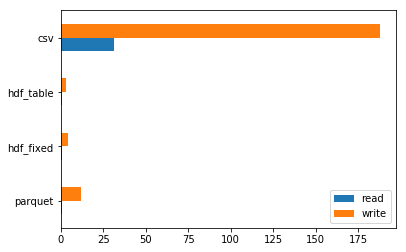

In [47]:
text_num = pd.concat([pd.DataFrame(data).mean().to_frame(f) for f, data in results.items()], axis=1).T
text_num[['read', 'write']].plot.barh();

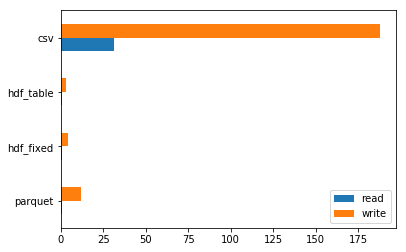

In [48]:
df = pd.concat([pd.DataFrame(data).mean().to_frame(f) for f, data in results.items()], axis=1).T
# df.to_csv('num_only.csv')
df[['read', 'write']].plot.barh();

In [ ]:
# for f, data in results.items():
#     pd.DataFrame(data).to_csv('{}.csv'.format(f))